# Preamble


In [ ]:
# Importing essential libraries and modules

import numpy as np
# NumPy is used for numerical operations on arrays, such as mathematical computations.

import torch
# PyTorch is a deep learning framework for tensor operations and building neural networks.

import torch.nn as nn
# nn provides modules to define and work with neural network layers.

import torchvision.models as models
# torchvision.models contains pre-trained models for computer vision tasks.

import torch.nn.functional as F
# F contains functions for common operations, such as activation functions, loss computations, etc.

from tqdm import tqdm
# tqdm provides a progress bar for loops, making it easier to track progress in iterative operations.

import matplotlib.pyplot as plt
# Matplotlib is used for creating static, animated, or interactive visualizations in Python.

import cv2
# OpenCV is used for image processing tasks, such as reading, writing, and manipulating images.

from PIL import Image
# PIL (Pillow) is another library for image processing, specifically for opening, manipulating, and saving images.

from diffusers import StableDiffusionPipeline
# StableDiffusionPipeline is part of the diffusers library, often used for generating or working with diffusion-based generative models.

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
# skimage.metrics provides functions for assessing image quality.
# psnr: Measures the peak signal-to-noise ratio, a metric for image quality.
# ssim: Measures structural similarity between two images.

from scipy.stats import entropy
# Entropy is used to compute the Shannon entropy, often used in information theory or for measuring randomness.

import torchvision.transforms as T
# T provides common image transformations, such as resizing, cropping, normalization, etc.

from typing import Tuple, Dict
# Typing helps specify types for variables, functions, and return values for better code readability and static analysis.
# Tuple: Represents fixed-length sequences of values.
# Dict: Represents key-value pairs.

import math
# Math library provides mathematical functions like square root, trigonometric functions, etc.

import zipfile
# zipfile is used for working with ZIP files, including reading, writing, and extracting files.

import os
# OS module is used to interact with the operating system, such as file manipulation, directory changes, etc.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Implementation of Paper


## Data Generation



In [ ]:
# Load the pre-trained Stable Diffusion model pipeline
pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base")

# Move the pipeline to GPU for faster processing
pipeline = pipeline.to("cuda")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# List of prompts for generating medical images
prompts = [
    "CT scan of a human brain",
    "MRI of the human spine",
    "PET scan of a human brain",
    "Ultrasound image of a human kidney"
]

# Repeat prompts to ensure 10 total prompts
prompts = prompts * (10 // len(prompts))

# List to store generated grayscale images
generated_images = []

# Generate images for each prompt
for i, prompt in enumerate(prompts):
    print(f"Generating image for: {prompt}")
    image = pipeline(prompt).images[0]  # Generate image using the pipeline
    grayscale_image = Image.fromarray(np.array(image)).convert("L")  # Convert to grayscale

    generated_images.append(np.array(grayscale_image))  # Save the grayscale image as an array
    print(f"Saved: medical_image_{i+1}.png")


Generating image for: CT scan of a human brain


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_1.png
Generating image for: MRI of the human spine


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_2.png
Generating image for: PET scan of a human brain


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_3.png
Generating image for: Ultrasound image of a human kidney


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_4.png
Generating image for: CT scan of a human brain


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_5.png
Generating image for: MRI of the human spine


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_6.png
Generating image for: PET scan of a human brain


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_7.png
Generating image for: Ultrasound image of a human kidney


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: medical_image_8.png


## Algorithim Implementation

In [ ]:
class ImageMetrics:
    @staticmethod
    def psnr(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        # Compute Peak Signal-to-Noise Ratio (PSNR) between two images
        img1 = img1.float()
        img2 = img2.float()
        if len(img1.shape) == 3 and img1.shape[0] == 3:  # Convert RGB to HxWxC
            img1 = img1.permute(1, 2, 0)
        if len(img2.shape) == 3 and img2.shape[0] == 3:
            img2 = img2.permute(1, 2, 0)

        # Handle grayscale and RGB conversion
        if len(img1.shape) == 2 and len(img2.shape) == 3:
            img1 = img1.unsqueeze(-1).repeat(1, 1, 3)
        elif len(img1.shape) == 3 and len(img2.shape) == 2:
            img2 = img2.unsqueeze(-1).repeat(1, 1, 3)
        mse = torch.mean((img1 - img2) ** 2)
        if mse == 0:
            return float("inf")
        return 20 * torch.log10(255.0 / torch.sqrt(mse))

    @staticmethod
    def ssim(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        # Compute Structural Similarity Index Measure (SSIM) between two images
        C1 = (0.01 * 255)**2
        C2 = (0.03 * 255)**2
        img1 = img1.float()
        img2 = img2.float()
        if len(img1.shape) == 3 and img1.shape[0] == 3:
            img1 = img1.permute(1, 2, 0)
        if len(img2.shape) == 3 and img2.shape[0] == 3:
            img2 = img2.permute(1, 2, 0)

        # Handle grayscale and RGB conversion
        if len(img1.shape) == 2 and len(img2.shape) == 3:
            img1 = img1.unsqueeze(-1).repeat(1, 1, 3)
        elif len(img1.shape) == 3 and len(img2.shape) == 2:
            img2 = img2.unsqueeze(-1).repeat(1, 1, 3)
        mean1 = torch.mean(img1)
        mean2 = torch.mean(img2)
        std1 = torch.std(img1)
        std2 = torch.std(img2)
        cov = torch.mean((img1 - mean1) * (img2 - mean2))

        return ((2 * mean1 * mean2 + C1) * (2 * cov + C2)) / \
               ((mean1**2 + mean2**2 + C1) * (std1**2 + std2**2 + C2))

    @staticmethod
    def entropy(img: torch.Tensor) -> torch.Tensor:
        # Compute entropy of an image
        hist = torch.histc(img.float(), bins=256, min=0, max=255)
        hist = hist / hist.sum()
        return -torch.sum(hist * torch.log2(hist + 1e-7))

    @staticmethod
    def std_dev(img: torch.Tensor) -> torch.Tensor:
        # Compute standard deviation of pixel values
        return torch.std(img.float())

    @staticmethod
    def mse(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        # Compute Mean Squared Error (MSE) between two images
        img1 = img1.float()
        img2 = img2.float()
        if len(img1.shape) == 3 and img1.shape[0] == 3:
            img1 = img1.permute(1, 2, 0)
        if len(img2.shape) == 3 and img2.shape[0] == 3:
            img2 = img2.permute(1, 2, 0)

        # Handle grayscale and RGB conversion
        if len(img1.shape) == 2 and len(img2.shape) == 3:
            img1 = img1.unsqueeze(-1).repeat(1, 1, 3)
        elif len(img1.shape) == 3 and len(img2.shape) == 2:
            img2 = img2.unsqueeze(-1).repeat(1, 1, 3)
        return torch.sum((img1 - img2) ** 2)

    @staticmethod
    def coc(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        # Compute Correlation Coefficient (CoC) between two images
        img1 = img1.float()
        img2 = img2.float()
        if len(img1.shape) == 3 and img1.shape[0] == 3:
            img1 = img1.permute(1, 2, 0)
        if len(img2.shape) == 3 and img2.shape[0] == 3:
            img2 = img2.permute(1, 2, 0)

        # Handle grayscale and RGB conversion
        if len(img1.shape) == 2 and len(img2.shape) == 3:
            img1 = img1.unsqueeze(-1).repeat(1, 1, 3)
        elif len(img1.shape) == 3 and len(img2.shape) == 2:
            img2 = img2.unsqueeze(-1).repeat(1, 1, 3)
        mean1 = torch.mean(img1)
        mean2 = torch.mean(img2)
        cov = torch.mean((img1 - mean1) * (img2 - mean2))
        std1 = torch.std(img1)
        std2 = torch.std(img2)
        return cov / (std1 * std2)


In [ ]:
class ClipLimitEstimator:
    @staticmethod
    def estimate_clip_limit(metrics: Dict[str, float]) -> float:
        """
        Implements equation 10 from the paper for clip limit estimation
        """
        X = metrics
        beta_psnr = 4.801e-5 * torch.sin(X['psnr'] - math.pi) + \
                    1.732e-5 * (X['psnr'] - 10)**2 - 0.00361/X['psnr']

        beta_ssim = -41.88 * torch.sin(X['ssim'] - math.pi) + \
                    1.427 * (X['ssim'] - 10)**2 - 151/X['ssim']

        beta_coc = -23.24 * torch.sin(X['coc'] - math.pi) + \
                   0.7188 * (X['coc'] - 10)**2 - 77.78/X['coc']

        beta_mse = 8.993e-5 * torch.sin(X['mse'] - math.pi) - \
                   5.798e-8 * (X['mse'] - 10)**2 + 0.002474/X['mse']

        beta_entropy = 1.216 * torch.sin(X['entropy'] - math.pi) - \
                      0.1245 * (X['entropy'] - 10)**2 + 1.934/X['entropy']

        beta_std = -0.01488 * torch.sin(X['std_dev'] - math.pi) + \
                   2.2e-5 * (X['std_dev'] - 10)**2 - 0.03428/X['std_dev']

        betas = torch.stack([beta_psnr, beta_ssim, beta_coc, beta_mse, beta_entropy, beta_std])
        return torch.sum(betas)

In [ ]:
def clahe(image, clip_limit):
    # Convert to grayscale if the image has 3 channels (RGB)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Create CLAHE object with specified clip limit
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit))
    
    # Apply CLAHE to the image and return the result
    return clahe.apply(image)


In [ ]:
class PelicanOptimizer:
    def __init__(self, population_size: int = 10, max_iter: int = 100):
        # Initialize population size, max iterations, metrics, and clip estimator
        self.population_size = population_size
        self.max_iter = max_iter
        self.metrics = ImageMetrics()
        self.clip_estimator = ClipLimitEstimator()

    def optimize(self, image: torch.Tensor) -> float:
        # Initialize random population of clip limits
        population = torch.rand(self.population_size, 1) * 9 + 1
        best_solution = None
        best_fitness = float('-inf')

        for iteration in tqdm(range(self.max_iter)):
            # Evaluate fitness for each pelican (clip limit)
            fitness_values = []
            for clip_limit in population:
                enhanced = self._apply_clahe_(image, clip_limit.item())  # Apply CLAHE
                metrics = self._calculate_metrics_(image, enhanced)  # Calculate metrics
                fitness = self._calculate_fitness_(metrics)  # Calculate fitness
                fitness_values.append(fitness)

            fitness_tensor = torch.tensor(fitness_values)
            current_best_idx = torch.argmax(fitness_tensor)

            # Update best solution if a better fitness is found
            if fitness_values[current_best_idx] > best_fitness:
                best_fitness = fitness_values[current_best_idx]
                best_solution = population[current_best_idx].clone()

            # Update population based on the best solution
            population = self._update_population_(population, best_solution, iteration)

        return best_solution.item()

    def _apply_clahe_(self, image: torch.Tensor, clip_limit: float) -> torch.Tensor:
        # Convert image to uint8 format and apply CLAHE
        img_np = (image.cpu().numpy() * 255).astype(np.uint8)
        if len(img_np.shape) == 3:  # If color image, convert to grayscale
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=clip_limit)
        enhanced = clahe.apply(img_np)
        return torch.from_numpy(enhanced)

    def _calculate_metrics_(self, original: torch.Tensor, enhanced: torch.Tensor) -> Dict[str, float]:
        # Calculate various metrics (PSNR, SSIM, entropy, etc.) between original and enhanced images
        return {
            'psnr': self.metrics.psnr(original, enhanced),
            'ssim': self.metrics.ssim(original, enhanced),
            'entropy': self.metrics.entropy(enhanced),
            'std_dev': self.metrics.std_dev(enhanced),
            'mse': self.metrics.mse(original, enhanced),
            'coc': self.metrics.coc(original, enhanced)
        }

    def _calculate_fitness_(self, metrics: Dict[str, float]) -> float:
        # Estimate fitness based on metrics using clip limit estimator
        return self.clip_estimator.estimate_clip_limit(metrics)

    def _update_population_(self, population: torch.Tensor, best_solution: torch.Tensor,
                            iteration: int) -> torch.Tensor:
        # Update population based on the best solution and current iteration
        for i in range(self.population_size):
            if torch.rand(1) < 0.5:
                population[i] = population[i] + torch.rand(1) * (best_solution - torch.rand(1) * population[i])
            else:
                population[i] = population[i] + torch.rand(1) * (population[i] - best_solution)

            R = 2
            t = iteration
            T = self.max_iter
            population[i] = population[i] + R * (1 - t/T) * (2 * torch.rand(1) - 1) * population[i]
            population[i] = torch.clamp(population[i], 1, 10)

        return population


## Reproducing Results

In [ ]:
# Calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(original, enhanced):
    # Convert tensors to numpy arrays if necessary
    if isinstance(original, torch.Tensor):
        original = original.cpu().numpy()
    if isinstance(enhanced, torch.Tensor):
        enhanced = enhanced.cpu().numpy()
    
    # Convert to grayscale if the image has 3 channels (RGB)
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    if len(enhanced.shape) == 3:
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_RGB2GRAY)

    # Calculate MSE (Mean Squared Error) between original and enhanced
    mse = np.mean((original - enhanced) ** 2)
    
    # If MSE is 0, return infinite PSNR (perfect similarity)
    if mse == 0:
        return float('inf')
    
    max_pixel = 255.0  # Maximum pixel value for 8-bit images
    # PSNR formula
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Calculate SSIM (Structural Similarity Index)
def calculate_ssim(original, enhanced):
    # Convert tensors to numpy arrays if necessary
    if isinstance(original, torch.Tensor):
        original = original.cpu().numpy()
    if isinstance(enhanced, torch.Tensor):
        enhanced = enhanced.cpu().numpy()

    # Convert to grayscale if the image has 3 channels (RGB)
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    if len(enhanced.shape) == 3:
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_RGB2GRAY)
    
    # If the original and enhanced images have different shapes, resize the enhanced image
    if original.shape != enhanced.shape:
        print(f"Original shape: {original.shape}, Enhanced shape: {enhanced.shape}")
        enhanced = cv2.resize(enhanced, (original.shape[1], original.shape[0]))
    
    # Return SSIM score
    return ssim(original, enhanced, data_range=enhanced.max() - enhanced.min())

# Calculate MSE (Mean Squared Error)
def calculate_mse(original, enhanced):
    # Convert tensors to numpy arrays if necessary
    if isinstance(original, torch.Tensor):
        original = original.cpu().numpy()
    if isinstance(enhanced, torch.Tensor):
        enhanced = enhanced.cpu().numpy()
    
    # Convert to grayscale if the image has 3 channels (RGB)
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    if len(enhanced.shape) == 3:
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_RGB2GRAY)
    
    # Return MSE (Mean Squared Error)
    return np.mean((original - enhanced) ** 2)

# Calculate Entropy (measure of randomness or information content)
def calculate_entropy(image):
    from scipy.stats import entropy
    # Convert tensor to numpy array if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    
    # Convert to grayscale if the image has 3 channels (RGB)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the histogram of the image
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 255))
    
    # Return entropy (information content of the image)
    return entropy(histogram, base=2)

# Calculate CoC (Coefficient of Contrast, ratio of standard deviation to mean)
def calculate_coc(image):
    # Convert tensor to numpy array if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # Convert to grayscale if the image has 3 channels (RGB)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Calculate mean and standard deviation of the image
    mean = np.mean(image)
    std_dev = np.std(image)

    # To avoid division by zero, return 0 if the mean is 0
    if mean == 0:
        return 0

    # Return CoC (Coefficient of Contrast)
    coc = std_dev / mean
    return coc

# Calculate SD (Standard Deviation)
def calculate_sd(image):
    # Convert tensor to numpy array if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    
    # Convert to grayscale if the image has 3 channels (RGB)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Return the standard deviation of the image
    return np.std(image)

# Plot a comparison of different methods based on a specific metric
def comparison_plot(metrics, methods, metric_name):
    plt.figure(figsize=(10, 5))
    plt.bar(methods, metrics, color='skyblue')  # Bar plot of metrics for each method
    plt.xlabel("Methods")
    plt.ylabel(metric_name)
    plt.title(f"Comparison of {metric_name} Across Methods")
    plt.xticks(rotation=45)  # Rotate method names for better visibility
    plt.tight_layout()
    plt.show()

# Plot the variation of metrics with respect to clip limits
def plot_metric_variation(metrics, clip_limits):
    # Ensure the clip limits and metrics have the same length
    valid_len = min(len(clip_limits), len(metrics["PSNR"]))
    clip_limits = clip_limits[:valid_len]
    
    # Truncate metrics to match the length of clip_limits
    for key in metrics:
        metrics[key] = metrics[key][:valid_len]

    # Create a 3x2 subplot for displaying metric variations
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))

    # Plot PSNR vs Clip Limit
    axes[0, 0].plot(clip_limits, metrics["PSNR"], color='blue')
    axes[0, 0].set_title("PSNR vs Clip Limit")
    axes[0, 0].set_xlabel("Clip Limit")
    axes[0, 0].set_ylabel("PSNR")

    # Plot SSIM vs Clip Limit
    axes[0, 1].plot(clip_limits, metrics["SSIM"], color='black')
    axes[0, 1].set_title("SSIM vs Clip Limit")
    axes[0, 1].set_xlabel("Clip Limit")
    axes[0, 1].set_ylabel("SSIM")

    # Plot MSE vs Clip Limit
    axes[1, 0].plot(clip_limits, metrics["MSE"], color='red')
    axes[1, 0].set_title("MSE vs Clip Limit")
    axes[1, 0].set_xlabel("Clip Limit")
    axes[1, 0].set_ylabel("MSE")

    # Plot Entropy vs Clip Limit
    axes[1, 1].plot(clip_limits, metrics["Entropy"], color='orange')
    axes[1, 1].set_title("Entropy vs Clip Limit")
    axes[1, 1].set_xlabel("Clip Limit")
    axes[1, 1].set_ylabel("Entropy")

    # Plot CoC vs Clip Limit
    axes[2, 0].plot(clip_limits, metrics["CoC"], color='green')
    axes[2, 0].set_title("CoC vs Clip Limit")
    axes[2, 0].set_xlabel("Clip Limit")
    axes[2, 0].set_ylabel("CoC")

    # Plot SD vs Clip Limit
    axes[2, 1].plot(clip_limits, metrics["SD"], color='purple')
    axes[2, 1].set_title("SD vs Clip Limit")
    axes[2, 1].set_xlabel("Clip Limit")
    axes[2, 1].set_ylabel("SD")

    # Adjust layout to avoid overlapping
    plt.tight_layout()
    plt.show()


In [ ]:
enhanced_images = []  # List to store enhanced images after processing
optimal_clip_limits = []  # List to store optimal clip limits for each image

# Dictionary to store calculated metrics for each image
metrics = {"PSNR": [], "SSIM": [], "MSE": [], "Entropy": [], "CoC": [], "SD": []}
clip_limits = np.linspace(0.0005, 0.003, 10)  # Range of clip limits for optimization

for i, image in enumerate(generated_images):

    image_tensor = torch.from_numpy(image)  # Convert image to tensor for optimization

    optimizer = PelicanOptimizer()  # Instantiate optimizer for clip limit optimization
    optimal_clip_limit = optimizer.optimize(image_tensor)  # Get optimal clip limit for current image
    optimal_clip_limits.append(optimal_clip_limit)  # Store optimal clip limit for later use

    enhanced_image = clahe(image, optimal_clip_limit)  # Apply CLAHE with the optimal clip limit

    enhanced_images.append(enhanced_image)  # Store the enhanced image for later analysis

    # Calculate and store performance metrics for the enhanced image
    psnr_value = calculate_psnr(image, enhanced_image)  # Peak Signal-to-Noise Ratio
    ssim_value = calculate_ssim(image, enhanced_image)  # Structural Similarity Index
    mse_value = calculate_mse(image, enhanced_image)  # Mean Squared Error
    entropy_value = calculate_entropy(enhanced_image)  # Entropy (Image Information Content)
    coc_value = calculate_coc(enhanced_image)  # Coefficient of Contrast
    sd_value = calculate_sd(enhanced_image)  # Standard Deviation (Image Contrast)

    # Append calculated metrics to respective lists in the metrics dictionary
    metrics["PSNR"].append(psnr_value)
    metrics["SSIM"].append(ssim_value)
    metrics["MSE"].append(mse_value)
    metrics["Entropy"].append(entropy_value)
    metrics["CoC"].append(coc_value)
    metrics["SD"].append(sd_value)



100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


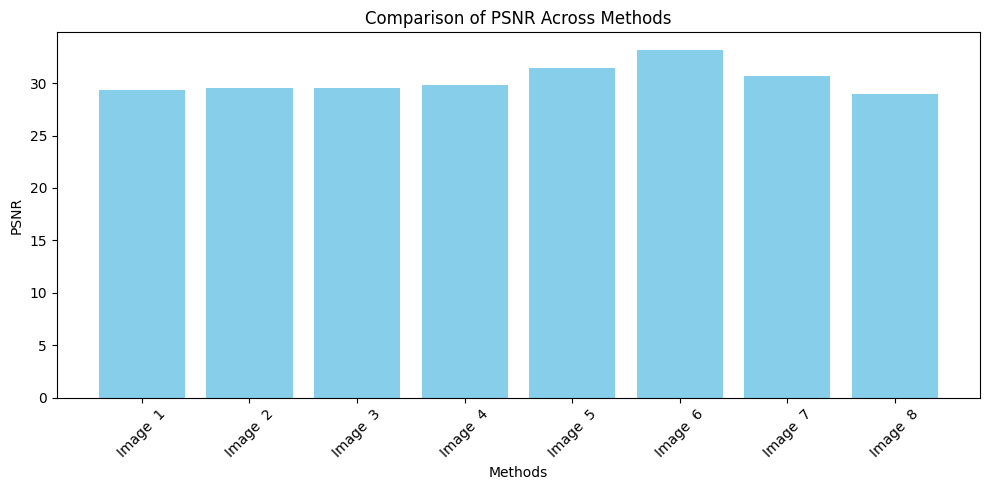

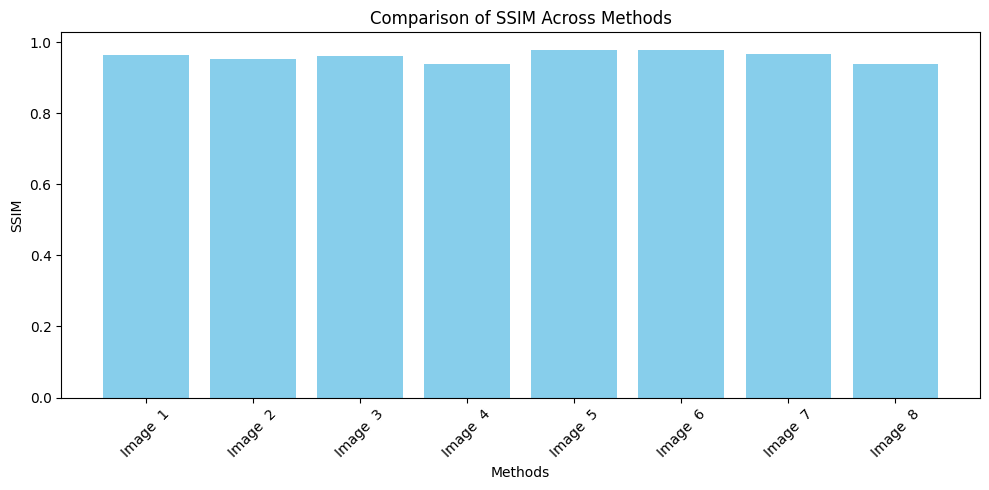

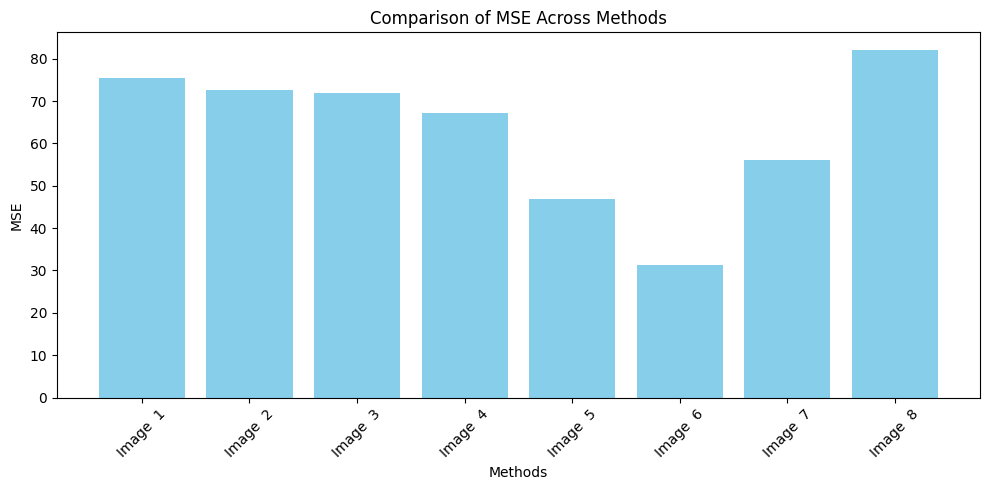

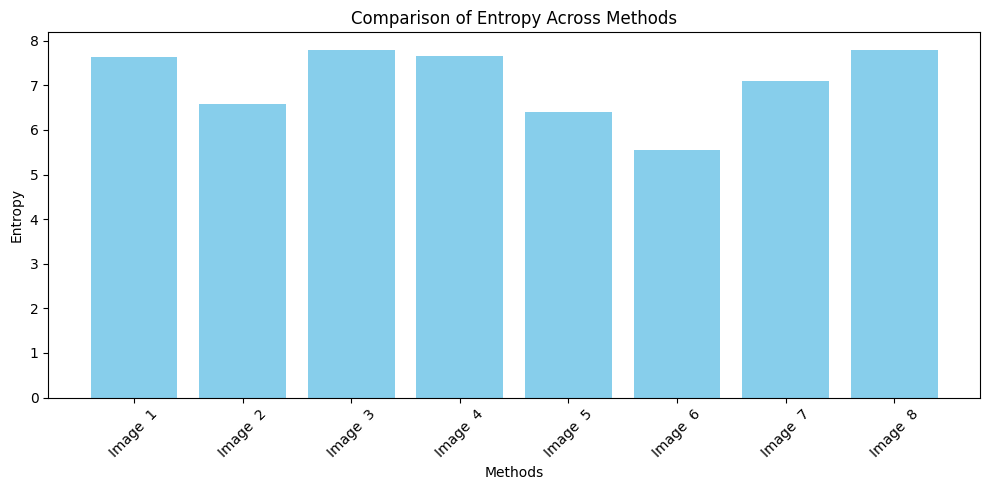

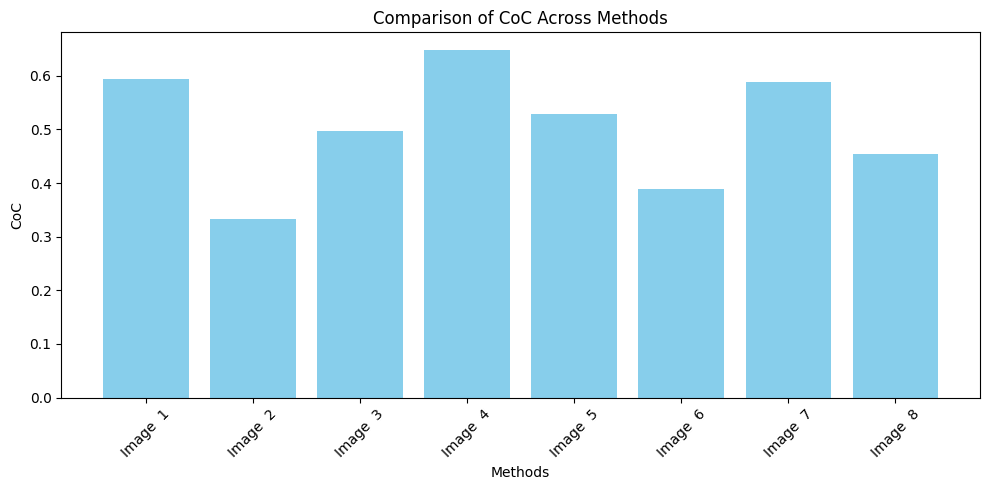

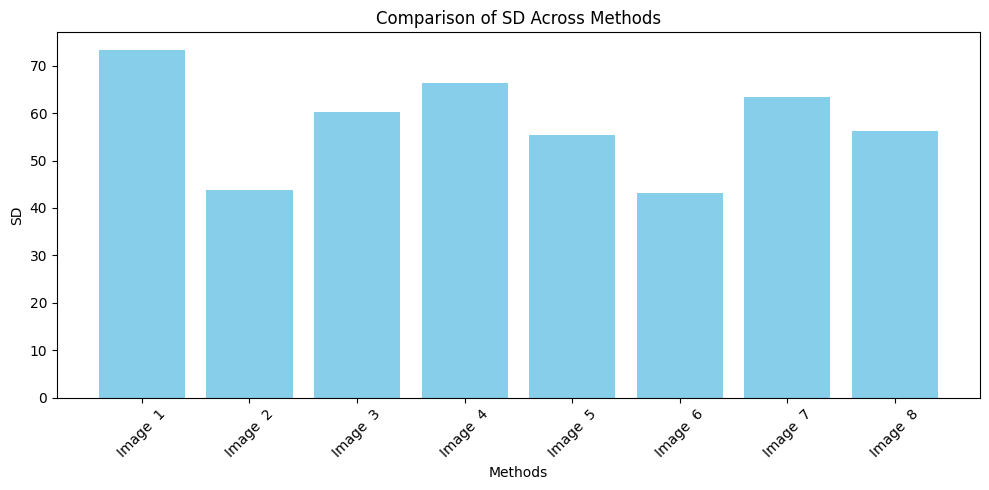

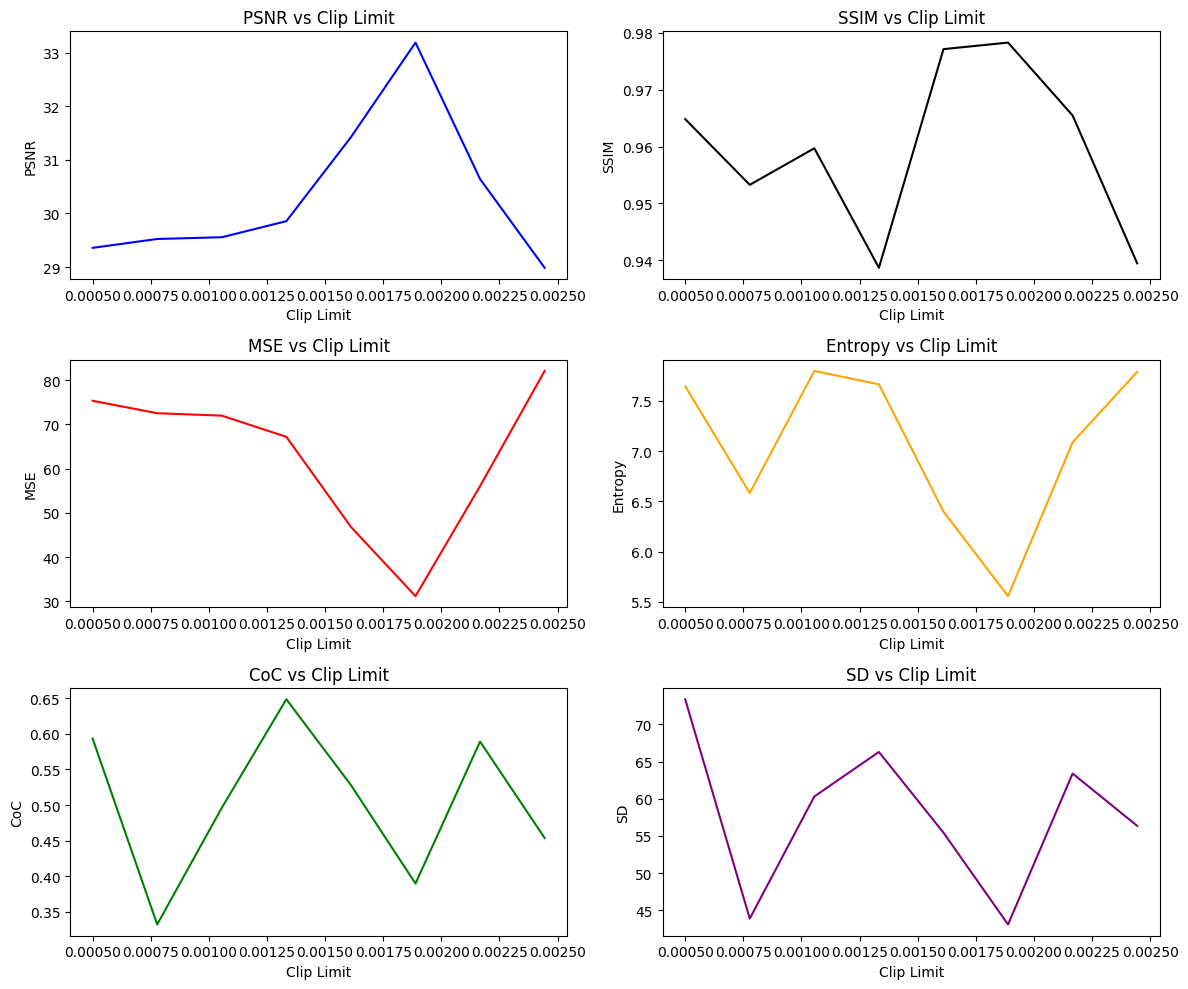

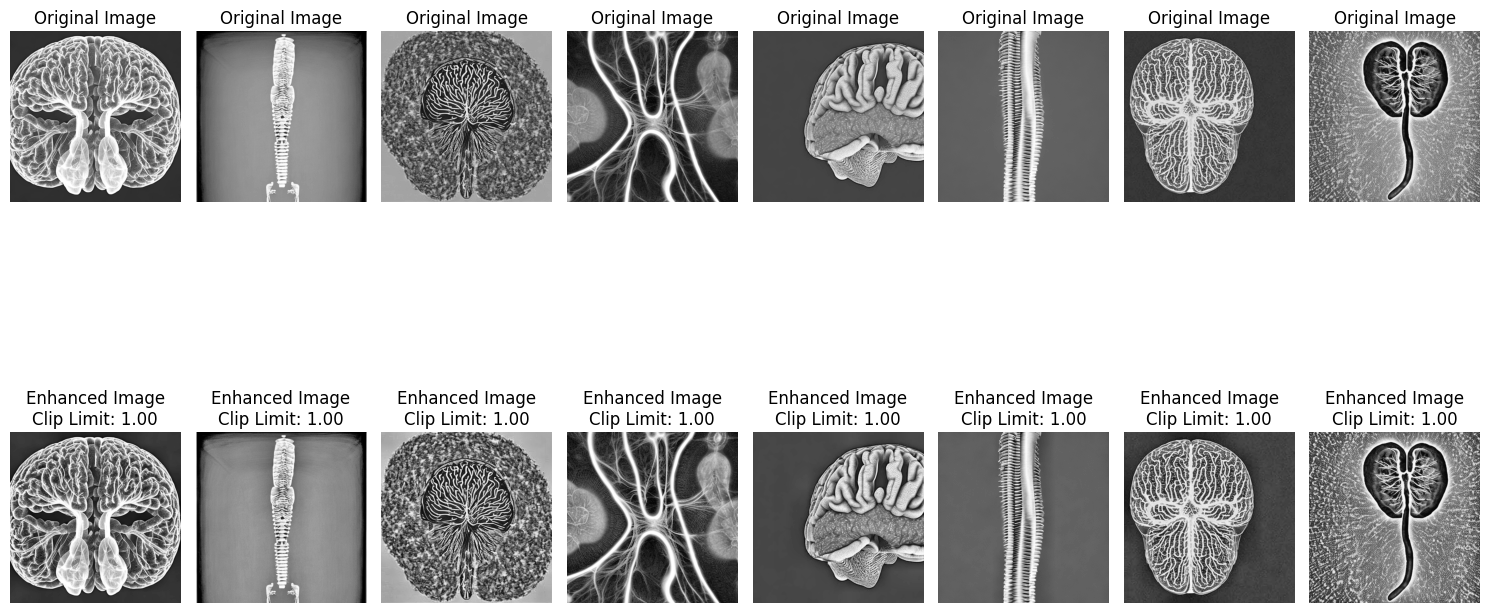

In [ ]:
# Visualization of Metrics
# Define the images to be compared (original ones) and methods (Image 1, Image 2, etc.)
images = generated_images
methods = [f"Image  {i+1}" for i in range(len(images))]

# Loop through each metric in 'metrics' dictionary and generate comparison plots
for metric_name, values in metrics.items():
    # 'comparison_plot' will plot the metrics' values for each image, with the respective method names
    comparison_plot(values, methods, metric_name)

# Plot how the metrics vary with different clip limits using 'plot_metric_variation'
plot_metric_variation(metrics, clip_limits)

# Set up subplots to display both original and enhanced images side by side
fig, axes = plt.subplots(2, len(images), figsize=(15, 10))

# Loop through each image to display them in the subplot
for i in range(len(images)):
    # Display the original image in the first row of subplots
    axes[0][i].imshow(images[i], cmap='gray')  # Use grayscale for better comparison
    axes[0][i].set_title("Original Image")  # Title for the original image
    axes[0][i].axis('off')  # Hide axis for better visual presentation

    # Display the enhanced image in the second row with the respective clip limit
    axes[1][i].imshow(enhanced_images[i], cmap='gray')  # Use grayscale for consistency
    axes[1][i].set_title(f"Enhanced Image\nClip Limit: {optimal_clip_limits[i]:.2f}")  # Title for the enhanced image with clip limit
    axes[1][i].axis('off')  # Hide axis for better visual presentation

# Adjust the layout for better spacing and clarity of the plots
plt.tight_layout()
plt.show()  # Display the final plots


# Extension of Paper


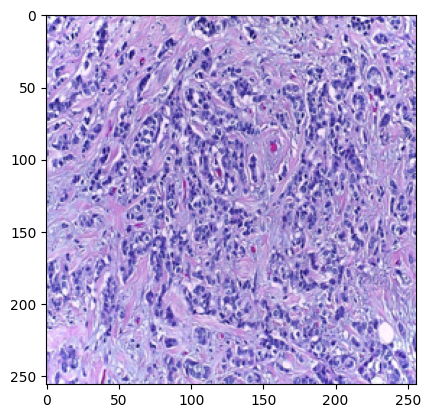

In [ ]:
# Initialize an empty list to store the processed histology images
histology_images = []

# Define the directory where the histology images are stored
directory = "/content/histology_files"

# Loop through all files in the specified directory
for filename in os.listdir(directory):
    # Check if the file is an image with supported extensions (TIFF, JPEG)
    if filename.lower().endswith(('.tif', '.tiff', '.jpeg')):
        # Get the full file path of the image
        filepath = os.path.join(directory, filename)
        
        try:
            # Open the image file
            image = Image.open(filepath)
            
            # Convert the image to RGB format in case it's not
            image = image.convert("RGB")
            
            # Resize the image to 256x256 pixels
            image = image.resize((256, 256))

            # Convert the image to a tensor (PyTorch format)
            transform = T.ToTensor()
            image_tensor = transform(image).permute(1, 2, 0)  # Change the tensor's dimensions for display
            histology_images.append(image_tensor)  # Add the processed image tensor to the list
            
        except Exception as e:
            # Print an error message if there's an issue opening or processing the image
            print(f"Error loading image '{filename}': {e}")

# Check if any images were successfully loaded
if histology_images:
    # If images are loaded, display the first image in the list
    plt.imshow(histology_images[0])  # Rearrange dimensions for display (height, width, channels)
    plt.show()
else:
    # If no images were loaded, print a message
    print("No TIFF images found in the specified directory.")


In [ ]:
class FeatureExtractor(nn.Module):
    # Constructor for the FeatureExtractor class
    def __init__(self):
        super().__init__()
        # Load the pre-trained ResNet-18 model
        resnet = models.resnet18(pretrained=True)
        
        # Extract all layers except the final two layers (fully connected and pooling layers)
        self.features = nn.Sequential(*list(resnet.children())[:-2])

    # Forward pass to extract features
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Ensure input is a 3-channel image, and handle potential input types

        # If the input is a NumPy array, convert it to a PyTorch tensor
        if isinstance(x, np.ndarray):  # Check if x is a NumPy array
            x = torch.tensor(x)
        
        # Convert the tensor to float type (since the model expects float inputs)
        x = x.float()
        
        # If the input tensor is 2D, add a batch dimension and replicate the channels to 3
        if x.dim() == 2:
            x = x.unsqueeze(0).repeat(1, 3, 1, 1)
        # If the input tensor is 3D (height, width, channels), add a batch dimension
        elif x.dim() == 3:
            x = x.unsqueeze(0)

        # Pass the input through the feature extractor layers of the pre-trained ResNet-18
        return self.features(x)


In [ ]:
class EnhancementMetrics:
    # Constructor to initialize the FeatureExtractor and set it to evaluation mode
    def __init__(self):
        # Initialize the feature extractor using the pre-defined FeatureExtractor class
        self.feature_extractor = FeatureExtractor()
        # Set the model to evaluation mode to disable dropout and batch normalization during inference
        self.feature_extractor.eval()

    # Method to calculate feature-based enhancement metrics
    def calculate_feature_metrics(self, image: torch.Tensor, enhanced: torch.Tensor) -> Dict[str, torch.Tensor]:
        # Disable gradient calculation during metric computation to save memory
        with torch.no_grad():
            # Extract features from both the original and enhanced images
            orig_features = self.feature_extractor(image)
            enhanced_features = self.feature_extractor(enhanced)

            # Return a dictionary with calculated feature-based metrics
            return {
                # Cosine similarity between original and enhanced features, averaged across the batch
                'feature_similarity': F.cosine_similarity(
                    orig_features.view(1, -1),  # Flatten the feature maps for comparison
                    enhanced_features.view(1, -1)  # Flatten the feature maps for comparison
                ).mean(),

                # Pairwise distance between original and enhanced features, averaged across the batch
                'feature_distance': F.pairwise_distance(
                    orig_features.view(1, -1),  # Flatten the feature maps for comparison
                    enhanced_features.view(1, -1)  # Flatten the feature maps for comparison
                ).mean(),

                # Standard deviation of the enhanced features
                'feature_std': enhanced_features.std(),

                # Mean value of the enhanced features
                'feature_mean': enhanced_features.mean(),
            }


In [ ]:
class FeatureExtracterPelicanOptimizer:
    # Constructor to initialize optimizer parameters and the metrics object
    def __init__(self, population_size: int = 30, max_iter: int = 100):
        self.population_size = population_size  # Set population size for the optimization
        self.max_iter = max_iter  # Set maximum number of iterations
        self.metrics = EnhancementMetrics()  # Initialize the metric calculation object

    # Objective function to be optimized. It computes the enhancement quality based on metrics
    def _objective_function_(self, image: torch.Tensor, clip_limit: float) -> torch.Tensor:
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) with the given clip limit
        enhanced = self._apply_clahe_(image, clip_limit)

        # Calculate feature-based metrics between the original and enhanced images
        metrics = self.metrics.calculate_feature_metrics(image, enhanced)

        # The objective combines multiple metrics: higher feature similarity and lower feature distance
        objective = (
            metrics['feature_similarity'] +  # Maximizing feature similarity
            (1 / (1 + metrics['feature_distance'])) +  # Minimizing feature distance (inverse)
            metrics['feature_std'] +  # Maximizing feature standard deviation (spread of features)
            metrics['feature_mean']  # Maximizing feature mean (central tendency)
        )

        return objective

    # Apply CLAHE enhancement to the input image
    def _apply_clahe_(self, image: torch.Tensor, clip_limit: float) -> torch.Tensor:
        # Convert the tensor to NumPy array and scale values to [0, 255] for CLAHE
        if image.ndimension() == 3 and image.shape[2] == 3:  # Color image
          img_np = (image.cpu().numpy() * 255).astype(np.uint8)
        else:  # Grayscale image
            img_np = (image.numpy() * 255).astype(np.uint8)

        # Check if the image is grayscale or color and apply CLAHE accordingly
        if img_np.ndim == 2:  # Grayscale image
            enhanced_np = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8)).apply(img_np)
        elif img_np.ndim == 3 and img_np.shape[2] == 3:  # Color image
            # Apply CLAHE to each color channel independently
            enhanced_np = np.zeros_like(img_np)
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
            for channel in range(3):
                enhanced_np[:, :, channel] = clahe.apply(img_np[:, :, channel])
        else:
            # Raise an error if the image is not of the expected format (grayscale or color)
            raise ValueError("Input image must be either grayscale (H, W) or color (H, W, 3).")

        # Normalize the enhanced image back to [0, 1] range
        enhanced_np = enhanced_np.astype(np.float32) / 255.0

        # Convert the NumPy array back to a PyTorch tensor
        return torch.from_numpy(enhanced_np)

    # Optimization function using a population-based approach to find the optimal clip limit
    def optimize(self, image: torch.Tensor) -> float:
        # Initialize population with random values between 1 and 10 for clip limit
        population = torch.rand(self.population_size, 1) * 9 + 1
        best_solution = None
        best_fitness = float('-inf')

        # Iterate for a fixed number of iterations
        for iteration in tqdm(range(self.max_iter)):
            fitness_values = []
            for clip_limit in population:
                # Calculate fitness of each population member based on its objective function value
                fitness = self._objective_function_(image, clip_limit.item())
                fitness_values.append(fitness)

            # Stack fitness values into a tensor
            fitness_tensor = torch.stack(fitness_values)
            # Get index of the best solution (highest fitness value)
            current_best_idx = torch.argmax(fitness_tensor)

            # If the current best solution has better fitness, update the best solution
            if fitness_values[current_best_idx] > best_fitness:
                best_fitness = fitness_values[current_best_idx]
                best_solution = population[current_best_idx].clone()

            # Update population for the next iteration
            population = self._update_population_(population, best_solution, iteration)

        # Return the best solution (optimal clip limit)
        return best_solution.item()

    # Update the population using a combination of exploration and exploitation
    def _update_population_(self, population: torch.Tensor, best_solution: torch.Tensor,
                        iteration: int) -> torch.Tensor:
      # Iterate over the population and update each member based on the best solution
      for i in range(self.population_size):
          # Exploration: random adjustment towards the best solution
          if torch.rand(1) < 0.5:
              population[i] = population[i] + torch.rand(1) * \
                            (best_solution - torch.rand(1) * population[i])
          # Exploitation: random adjustment based on the difference with the best solution
          else:
              population[i] = population[i] + torch.rand(1) * \
                            (population[i] - best_solution)

          # Apply temperature scaling for simulated annealing-like behavior
          R = 2
          t = iteration
          T = self.max_iter
          population[i] = population[i] + R * (1 - t/T) * \
                        (2 * torch.rand(1) - 1) * population[i]

          # Clamp population values to stay within the valid range [1, 10]
          population[i] = torch.clamp(population[i], 1, 10)

      return population


In [ ]:
def enhance_rgb_image(image_tensor):
    # Initialize lists for storing enhanced channels and metrics for each channel
    enhanced_channels = []
    optimal_clip_limits = []
    metrics = {"PSNR": [], "SSIM": [], "MSE": [], "Entropy": [], "CoC": [], "SD": []}

    # Check if the image is grayscale (2D tensor)
    if len(image_tensor.shape) == 2:  # Grayscale
        # Use the optimizer to find the optimal clip limit for the grayscale image
        optimizer = FeatureExtracterPelicanOptimizer(max_iter=10)
        optimal_clip_limit = optimizer.optimize(image_tensor)

        # Apply CLAHE enhancement to the grayscale image
        clahe_obj = cv2.createCLAHE(clipLimit=optimal_clip_limit, tileGridSize=(8, 8))
        enhanced_image = clahe_obj.apply(image_tensor)
        return enhanced_image

    # Process each channel in the RGB image (3 channels)
    for channel in range(3):
        channel_data = image_tensor[:,:,channel]  # Extract the channel data

        # Use the optimizer to find the optimal clip limit for the current channel
        optimizer = FeatureExtracterPelicanOptimizer(max_iter=10)
        optimal_clip_limit = optimizer.optimize(channel_data)
        optimal_clip_limits.append(optimal_clip_limit)

        # Apply CLAHE enhancement to the current channel
        clahe = cv2.createCLAHE(clipLimit=optimal_clip_limit, tileGridSize=(8,8))
        enhanced_channel = clahe.apply((channel_data.cpu().numpy() * 255).astype(np.uint8))
        enhanced_channels.append(enhanced_channel)

        # Convert the enhanced channel back to a tensor and normalize it
        enhanced_channel_tensor = torch.from_numpy(enhanced_channel).float() / 255.0

        # Calculate the PSNR (Peak Signal to Noise Ratio) for the enhanced channel
        try:
            metrics["PSNR"].append(float(calculate_psnr(channel_data, enhanced_channel_tensor)))
        except Exception as e:
            metrics["PSNR"].append(float('nan'))
            print(f"PSNR calculation error: {e}")

        # Calculate the SSIM (Structural Similarity Index) for the enhanced channel
        try:
            metrics["SSIM"].append(float(calculate_ssim(channel_data, enhanced_channel_tensor)))
        except Exception as e:
            metrics["SSIM"].append(float('nan'))
            print(f"SSIM calculation error: {e}")

        # Calculate the MSE (Mean Squared Error) for the enhanced channel
        try:
            metrics["MSE"].append(float(calculate_mse(channel_data, enhanced_channel_tensor)))
        except Exception as e:
            metrics["MSE"].append(float('nan'))
            print(f"MSE calculation error: {e}")

        # Calculate the Entropy of the enhanced channel
        try:
            metrics["Entropy"].append(float(calculate_entropy(enhanced_channel)))
        except Exception as e:
            metrics["Entropy"].append(float('nan'))
            print(f"Entropy calculation error: {e}")

        # Calculate the CoC (Coefficient of Contrast) for the enhanced channel
        try:
            metrics["CoC"].append(float(calculate_coc(enhanced_channel)))
        except Exception as e:
            metrics["CoC"].append(float('nan'))
            print(f"CoC calculation error: {e}")

        # Calculate the standard deviation (SD) of the enhanced channel
        try:
            metrics["SD"].append(float(calculate_sd(enhanced_channel)))
        except Exception as e:
            metrics["SD"].append(float('nan'))
            print(f"SD calculation error: {e}")

    # Combine the enhanced channels to form the final enhanced image
    enhanced_image = cv2.merge(enhanced_channels)

    # Calculate the average of each metric (if available)
    try:
        metrics = {k: np.mean(v) if v else None for k, v in metrics.items()}
    except Exception as e:
        print(f"Error in calculating metrics mean: {e}")
        print(f"Metrics content: {metrics}")

    # Return the enhanced image as a tensor, metrics, and the optimal clip limits
    return torch.from_numpy(enhanced_image).float() / 255.0, metrics, optimal_clip_limits


In [ ]:
enhanced_images = []
optimal_clip_limits = []

metrics = {"PSNR": [], "SSIM": [], "MSE": [], "Entropy": [], "CoC": [], "SD": []}

# Assuming clip_limits is defined for some parameter grid search
clip_limits_range = np.linspace(0.0005, 0.003, 10)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for i, image in enumerate(histology_images):
    # Enhance the image and get the metrics and optimal clip limits
    enhanced_rgb, image_metrics, optimal_clip_limits_image = enhance_rgb_image(image)
    enhanced_images.append(enhanced_rgb)

    # Calculate Metrics
    psnr_value = calculate_psnr(image, enhanced_rgb)
    ssim_value = calculate_ssim(image, enhanced_rgb)
    mse_value = calculate_mse(image, enhanced_rgb)
    entropy_value = calculate_entropy(enhanced_rgb)

    # Assuming calculate_coc and calculate_sd functions are defined
    coc_value = calculate_coc(enhanced_rgb)
    sd_value = calculate_sd(enhanced_rgb)

    # Append the calculated metrics
    metrics["PSNR"].append(psnr_value)
    metrics["SSIM"].append(ssim_value)
    metrics["MSE"].append(mse_value)
    metrics["Entropy"].append(entropy_value)
    metrics["CoC"].append(coc_value)
    metrics["SD"].append(sd_value)
    
    # Optionally, log the optimal clip limits
    optimal_clip_limits.append(optimal_clip_limits_image)

# After the loop, you will have enhanced images and corresponding metrics for each.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]
100%|██████████| 10/10 [01:10<00:00,  7.08s/it]


1


100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


1


100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


1


100%|██████████| 10/10 [01:07<00:00,  6.71s/it]

1


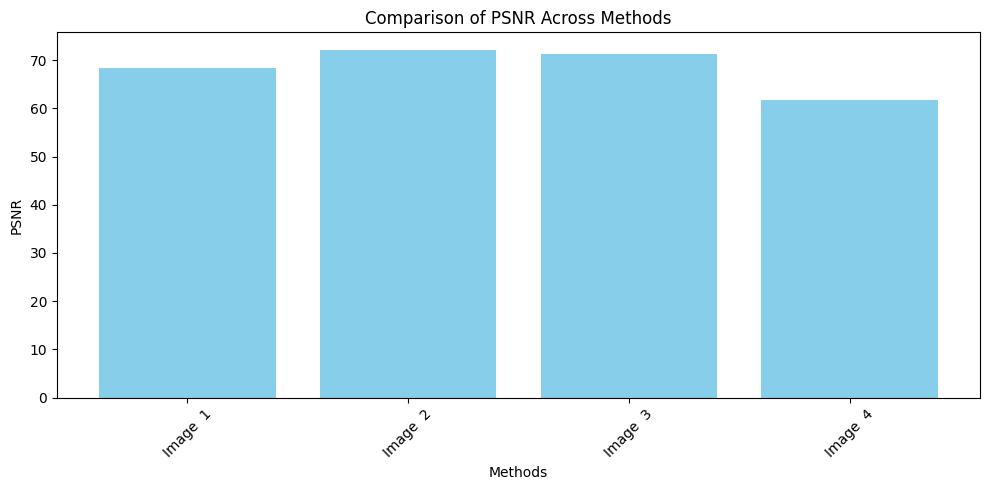

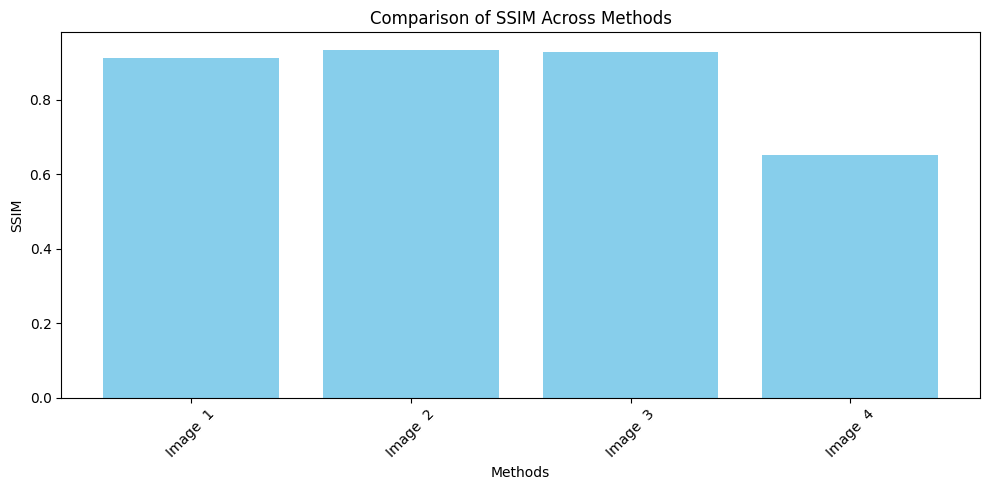

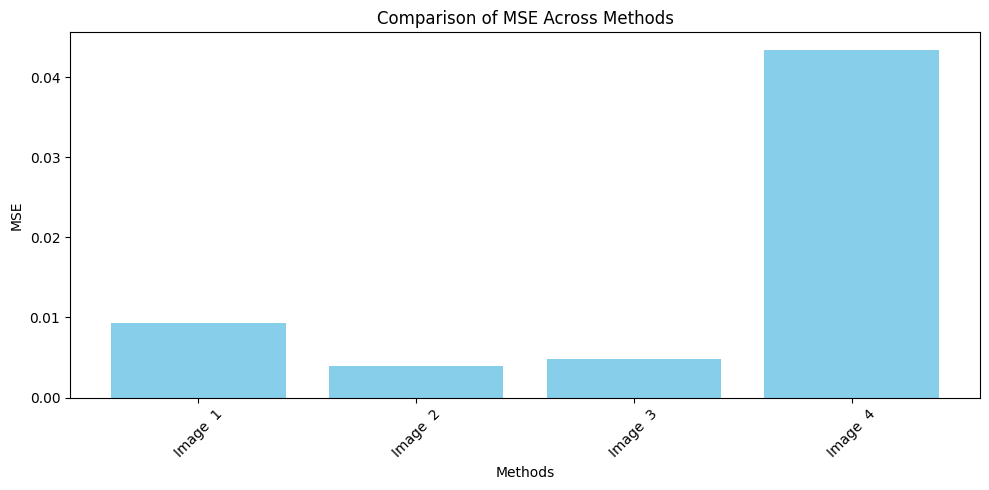

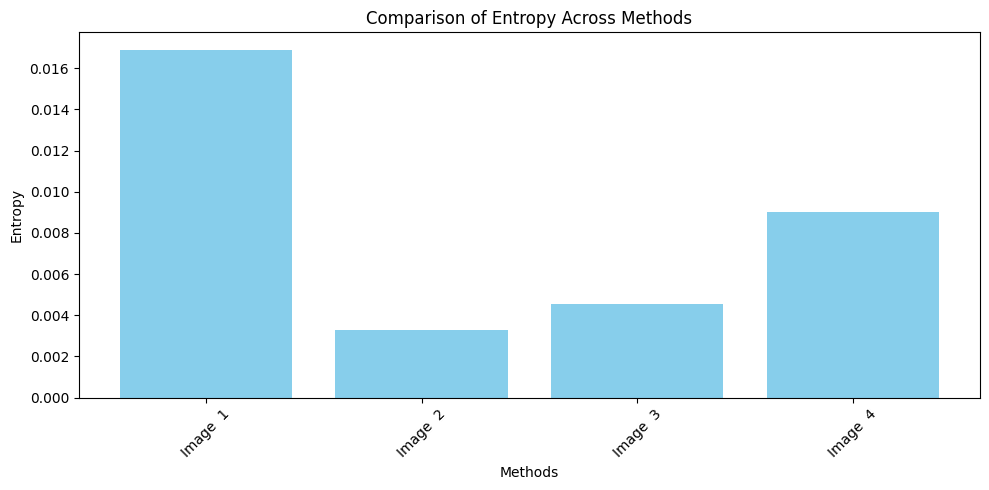

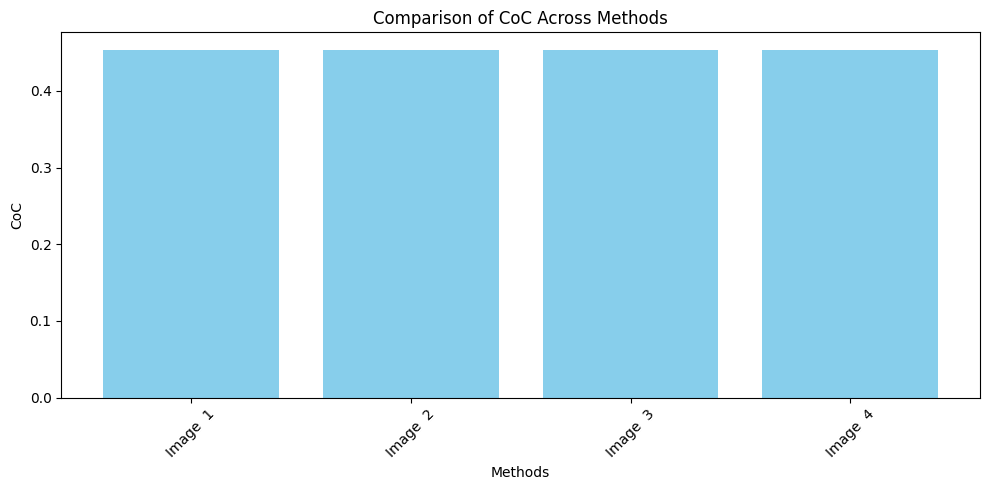

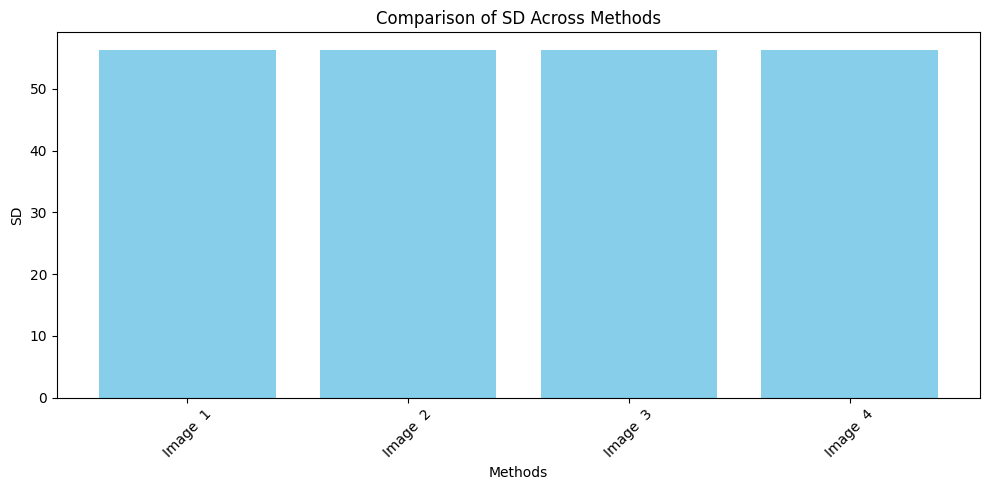

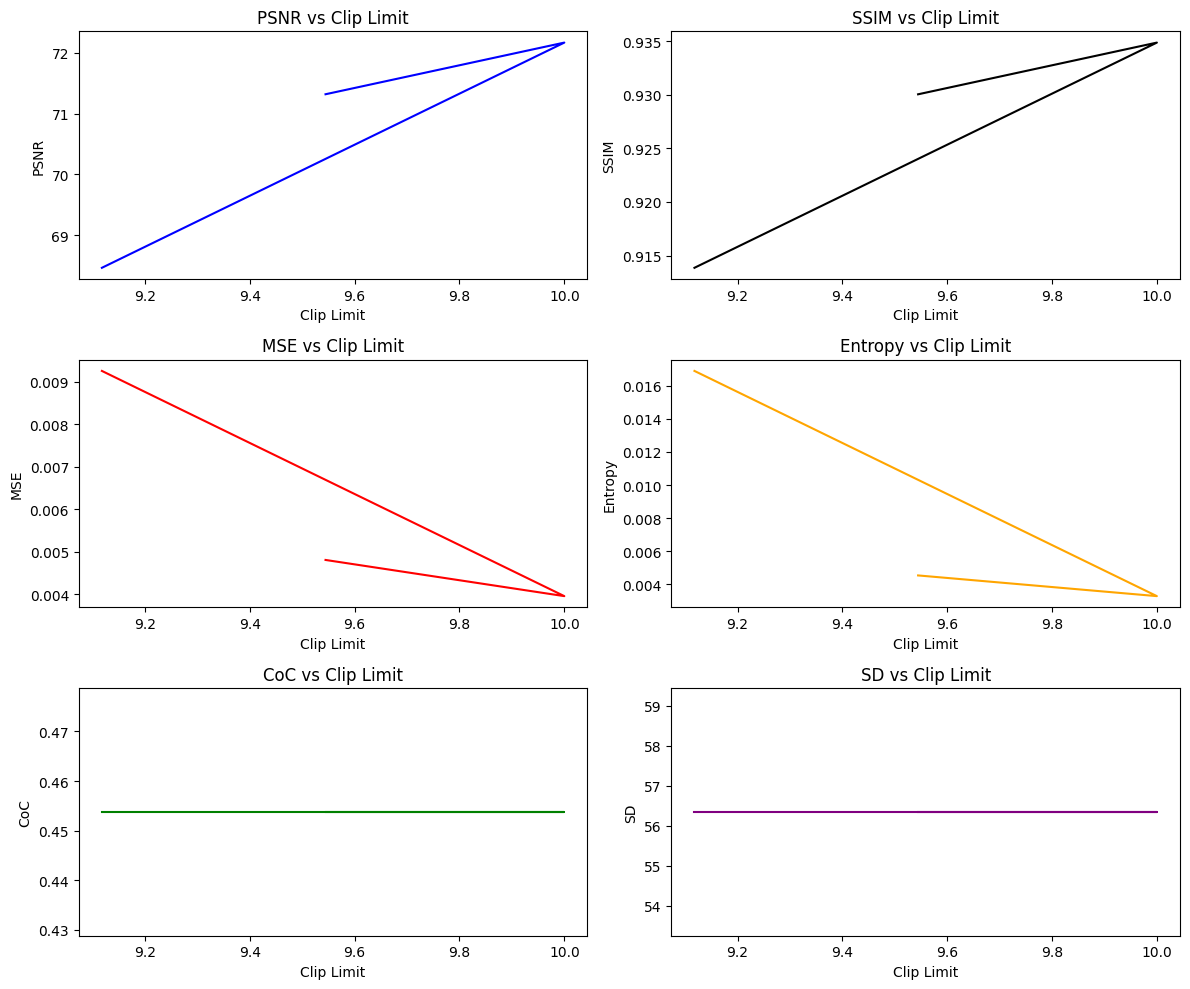

IndexError: list index out of range

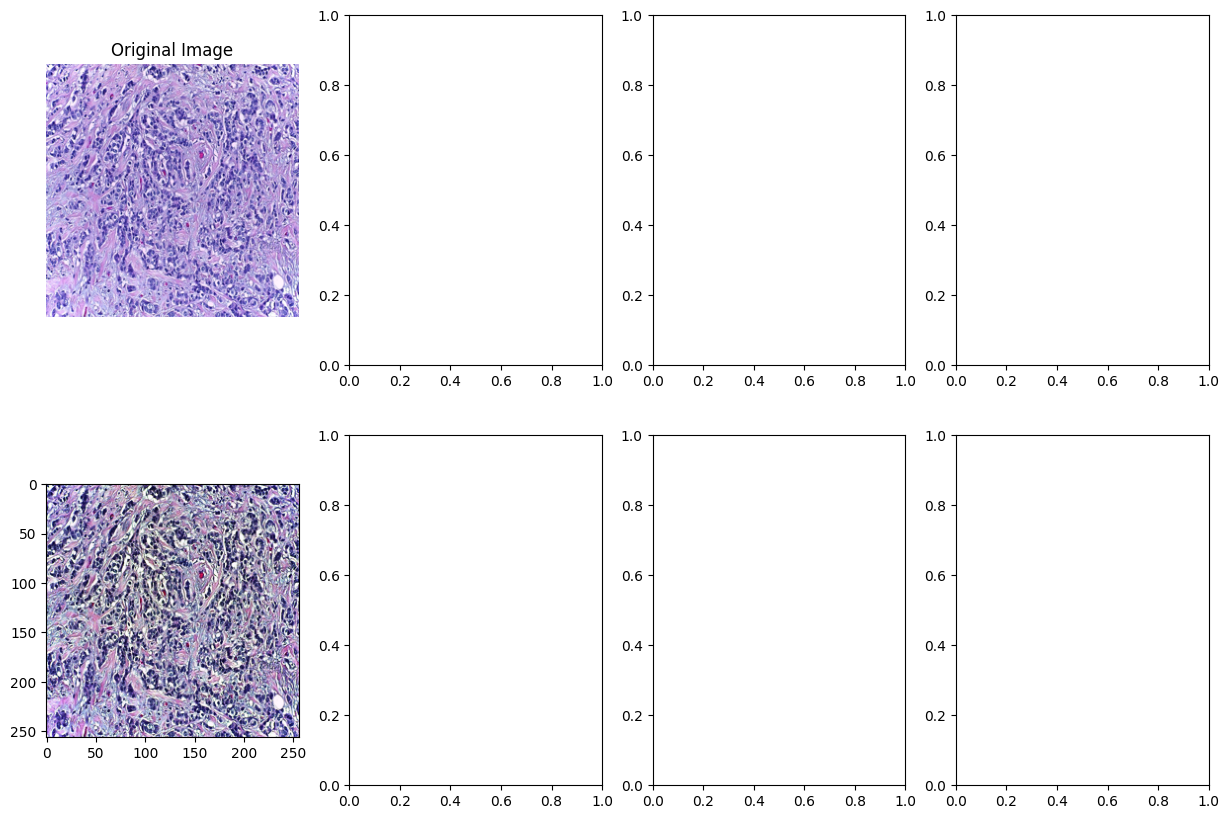

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure metrics length matches number of images
images = histology_images
num_images = len(images)

# Truncate metrics if necessary
for metric_name, values in metrics.items():
    if len(values) != num_images:
        # Truncate or handle mismatch appropriately
        metrics[metric_name] = values[:num_images]

# Generate method names for plotting (e.g., "Image 1", "Image 2", etc.)
methods = [f"Image {i+1}" for i in range(num_images)]

# Plotting the metric comparison
for metric_name, values in metrics.items():
    comparison_plot(values, methods, metric_name)

# Plot metric variation across clip limits
plot_metric_variation(metrics, clip_limits)

# Create a figure for displaying images and metrics
fig, axes = plt.subplots(2, len(images), figsize=(15, 10))

# Ensure axes are 2D even when there is only one image
if len(histology_images) == 1:
    axes = np.expand_dims(axes, axis=0)

# Display the original and enhanced images with titles
for i in range(len(images)):
    # Original Image
    axes[0][i].imshow(images[i], cmap='gray')
    axes[0][i].set_title("Original Image")
    axes[0][i].axis('off')

    # Enhanced Image
    axes[1][i].imshow(enhanced_images[i], cmap='gray')
    axes[1][i].set_title(f"Enhanced Image\nClip Limit: {optimal_clip_limits[i]:.2f}")
    axes[1][i].axis('off')

# Adjust layout for better spacing and display
plt.tight_layout()
plt.show()


# **Comparision with state-of-the-art filters and models**

In [ ]:
# Comparison with state-of-the-art filters
import numpy as np
import cv2
from skimage import restoration

# Wiener Filter: A noise reduction filter that works by considering the local mean and variance
def wiener_filter(image):
    # Check if image is a PyTorch tensor, if so, convert to numpy array
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # Ensure the image is in uint8 format before applying Wiener filter
    if image.dtype != np.uint8:
        image = np.uint8(image)
    # Apply Non-Local Means Denoising (a variant of Wiener filter) using OpenCV
    return cv2.fastNlMeansDenoising(image, None, 3, 7, 21)

# Gaussian Filter: A filter used to blur an image by applying a Gaussian function
def gaussian_filter(image):
    # Convert tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # Ensure the image is in uint8 format before applying Gaussian filter
    if image.dtype != np.uint8:
        image = np.uint8(image)
    # Apply Gaussian blur using OpenCV with a kernel size of 5x5
    return cv2.GaussianBlur(image, (5, 5), 0)

# Median Filter: A filter that replaces each pixel with the median of neighboring pixels
def median_filter(image):
    # Convert tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # Ensure the image is in uint8 format before applying Median filter
    if image.dtype != np.uint8:
        image = np.uint8(image)
    # Apply median blur using OpenCV with a kernel size of 5
    return cv2.medianBlur(image, 5)

# Unsharp Masking: Enhances edges by subtracting the blurred version of the image
def unsharp_masking(image):
    # Convert tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # Ensure the image is in uint8 format before applying Unsharp Masking
    if image.dtype != np.uint8:
        image = np.uint8(image)
    # Apply Gaussian blur and enhance edges using weighted addition
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    return cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

# Original Algorithm: CLAHE-based enhancement using Pelican Optimizer
def original_algo(image):
    # Convert tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()  # Convert tensor to numpy array if it's already a tensor

    # Convert to grayscale if the image is in RGB
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Ensure the image is in uint8 format before applying CLAHE
    if image.dtype != np.uint8:
        image = np.uint8(image)

    # Initialize optimizer (assumed to be implemented)
    optimizer = PelicanOptimizer()
    # Optimize the clip limit for CLAHE
    optimal_clip_limit = optimizer.optimize(image_tensor)
    optimal_clip_limits.append(optimal_clip_limit)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe_obj = cv2.createCLAHE(clipLimit=optimal_clip_limit, tileGridSize=(8, 8))
    enhanced_image = clahe_obj.apply(image)
    return enhanced_image

# Extended Algorithm: Applies RGB enhancement using the `enhance_rgb_image` function
def extended_algo(image):
    # Call the enhance_rgb_image function and return the enhanced image
    result = enhance_rgb_image(image)
    return result[0]  # Return the enhanced image (first element of the returned tuple)


In [ ]:
# Check if the generated image is a NumPy array, indicating it's not yet in PIL format
if isinstance(generated_images[0], np.ndarray):
    # Convert the first image in the generated images list to a PIL image
    image_pil = Image.fromarray(generated_images[0])  # Convert NumPy array to PIL image

# Resize the image to (256, 256) using PIL's resize method
image_resized = image_pil.resize((256, 256))

# If you need to convert the PIL image back to a NumPy array, use np.array
image_resized_np = np.array(image_resized)
# Now image is in NumPy array format with shape (256, 256, 3) or (256, 256)
image = image_resized_np

# Create a dictionary of different image processing techniques applied to the image
filters = {
    'Original Code': original_algo(image),  # Apply the original algorithm (CLAHE enhancement)
    'Wiener Filter': wiener_filter(image),  # Apply Wiener filtering for noise reduction
    'Gaussian Filter': gaussian_filter(image),  # Apply Gaussian blur for smoothing
    'Median Filter': median_filter(image),  # Apply median filtering for noise removal
    'Unsharp Masking': unsharp_masking(image),  # Apply unsharp masking for edge enhancement
    "Extended Code": extended_algo(image)  # Apply the extended enhancement algorithm (RGB processing)
}


100%|██████████| 10/10 [01:24<00:00,  8.50s/it]


In [ ]:
import matplotlib.pyplot as plt

def compare_and_plot(image):
    # Store results for different metrics
    results = {
        'PSNR': [],  # Peak Signal-to-Noise Ratio values
        'SSIM': [],  # Structural Similarity Index values
        'MSE': [],   # Mean Squared Error values
        'COC': [],   # Cumulative Output Change values
        'SD': [],    # Standard Deviation values
        'EL': []     # Edge Loss values
    }

    # Extract the names of the filters to use as x-axis labels
    filter_names = list(filters.keys())

    # Iterate over each filter and calculate the evaluation metrics
    for filter_name, filtered_image in filters.items():
        # Calculate PSNR for the current filter
        psnr_value = calculate_psnr(image, filtered_image)
        # Calculate SSIM for the current filter
        ssim_value = calculate_ssim(image, filtered_image)
        # Calculate MSE for the current filter
        mse_value = calculate_mse(image, filtered_image)
        # Calculate COC (Cumulative Output Change) for the current filter
        coc_value = calculate_coc(filtered_image)
        # Calculate standard deviation (SD) for the current filter
        sd_value = calculate_sd(filtered_image)
        # Calculate edge loss (EL) for the current filter
        entropy_value = calculate_entropy(filtered_image)

        # Append each metric's result to the corresponding list
        results['PSNR'].append(psnr_value)
        results['SSIM'].append(ssim_value)
        results['MSE'].append(mse_value)
        results['COC'].append(coc_value)
        results['SD'].append(sd_value)
        results['EL'].append(entropy_value)

    # Create a figure with multiple subplots for displaying comparison of metrics
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Flatten the 2D array of axes for easy iteration in the following steps
    axs = axs.flatten()

    # Plot PSNR as a bar graph
    axs[0].bar(filter_names, results['PSNR'], color='b')
    axs[0].set_xlabel('Filter / Model')
    axs[0].set_ylabel('PSNR')
    axs[0].set_title('PSNR for Different Filters')
    axs[0].tick_params(axis='x', rotation=45)

    # Plot SSIM as a bar graph
    axs[1].bar(filter_names, results['SSIM'], color='g')
    axs[1].set_xlabel('Filter / Model')
    axs[1].set_ylabel('SSIM')
    axs[1].set_title('SSIM for Different Filters')
    axs[1].tick_params(axis='x', rotation=45)

    # Plot MSE as a bar graph
    axs[2].bar(filter_names, results['MSE'], color='r')
    axs[2].set_xlabel('Filter / Model')
    axs[2].set_ylabel('MSE')
    axs[2].set_title('MSE for Different Filters')
    axs[2].tick_params(axis='x', rotation=45)

    # Plot COC as a bar graph
    axs[3].bar(filter_names, results['COC'], color='orange')
    axs[3].set_xlabel('Filter / Model')
    axs[3].set_ylabel('COC')
    axs[3].set_title('Cumulative Output Change (COC) for Different Filters')
    axs[3].tick_params(axis='x', rotation=45)

    # Plot SD as a bar graph
    axs[4].bar(filter_names, results['SD'], color='purple')
    axs[4].set_xlabel('Filter / Model')
    axs[4].set_ylabel('SD')
    axs[4].set_title('Standard Deviation (SD) for Different Filters')
    axs[4].tick_params(axis='x', rotation=45)

    # Plot EL (Entropy Loss) as a bar graph
    axs[5].bar(filter_names, results['EL'], color='brown')
    axs[5].set_xlabel('Filter / Model')
    axs[5].set_ylabel('Entropy Loss (EL)')
    axs[5].set_title('Entropy Loss (EL) for Different Filters')
    axs[5].tick_params(axis='x', rotation=45)

    # Adjust layout to prevent overlap of labels and titles
    plt.tight_layout()

    # Display the generated comparison plots
    plt.show()


Original shape: (256, 256), Enhanced shape: (256,)


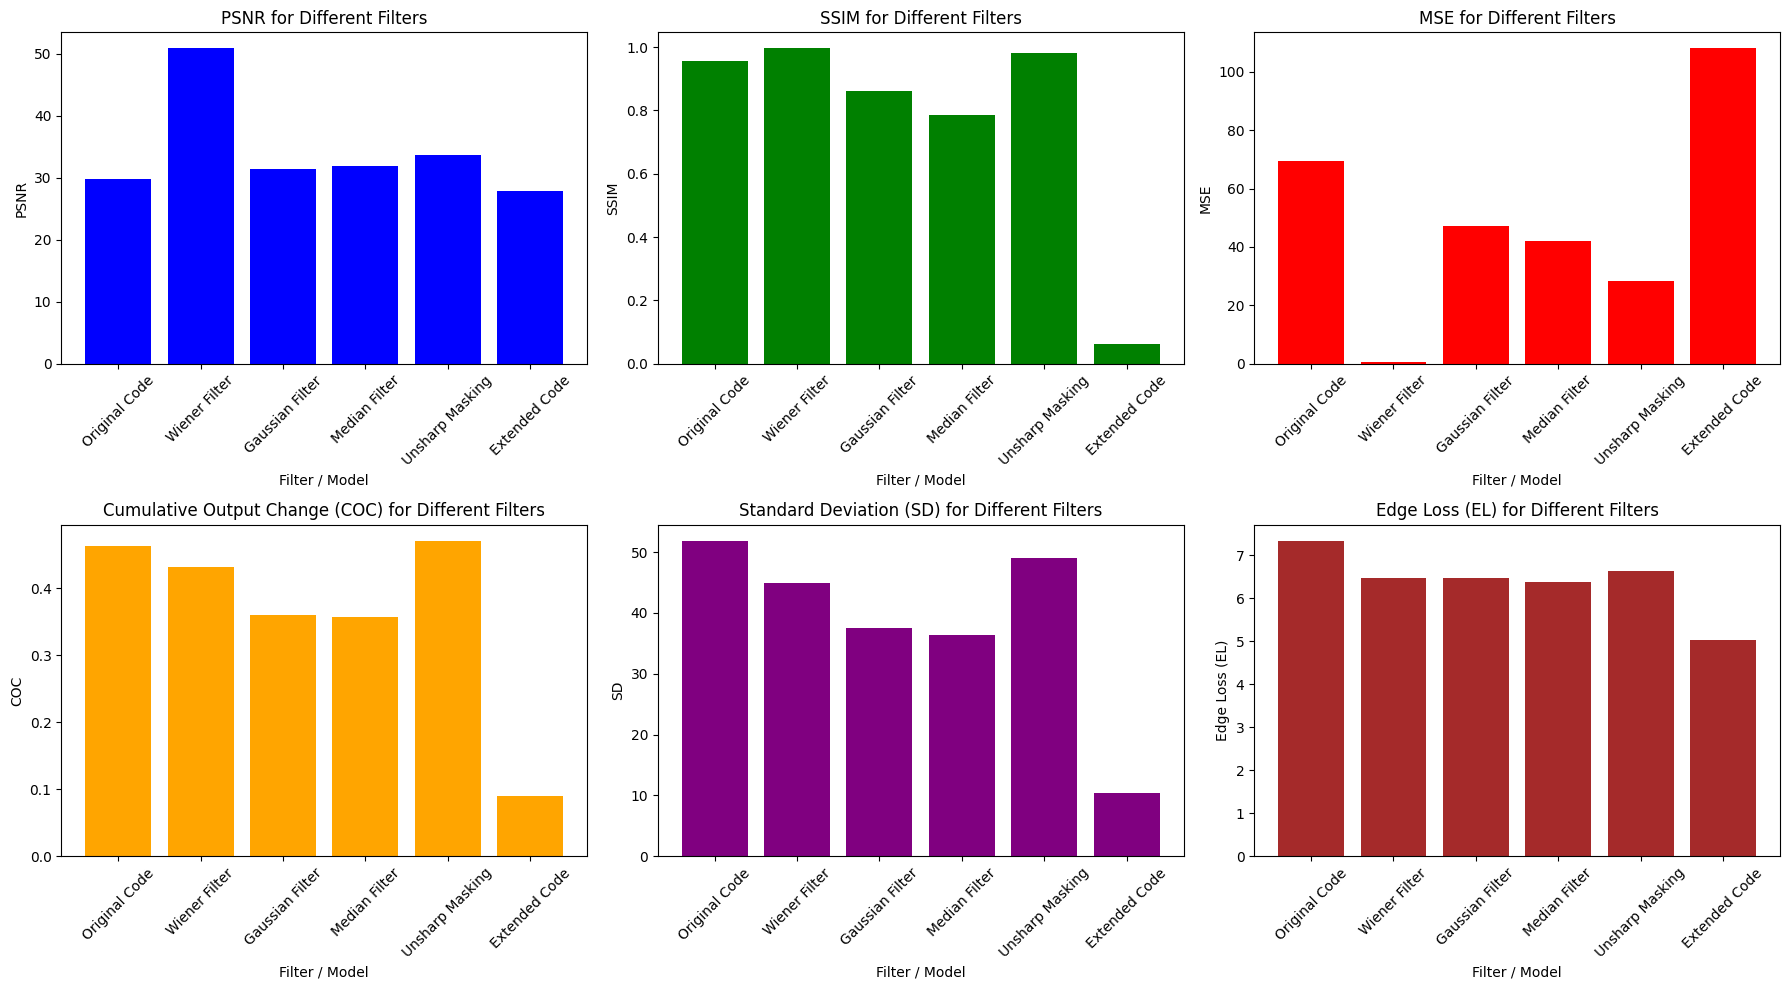

In [ ]:
# Plot the comparision for different filters and models on the original dataset
compare_and_plot(image)

In [ ]:
# Select the first image from the histology_images list
image = histology_images[0]

# Apply different filters to the image and store the results in the filters dictionary
filters = {
    # Apply the 'Original Code' filter (custom algorithm) to the image
    'Original Code': original_algo(image),  # Presumably applies CLAHE or a custom image enhancement technique
    
    # Apply Wiener filter to the image
    'Wiener Filter': wiener_filter(image),  # Noise reduction using Wiener filter
    
    # Apply Gaussian filter to the image
    'Gaussian Filter': gaussian_filter(image),  # Smoothing filter using Gaussian blur
    
    # Apply Median filter to the image
    'Median Filter': median_filter(image),  # Reduces salt-and-pepper noise by replacing pixels with the median value of neighbors
    
    # Apply Unsharp Masking to the image
    'Unsharp Masking': unsharp_masking(image),  # Enhances image details by subtracting a blurred version of the image
    
    # Apply the 'Extended Code' filter (a custom enhancement technique) to the image
    "Extended Code": extended_algo(image)  # Presumably applies CLAHE or another enhancement with extended processing
}


100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


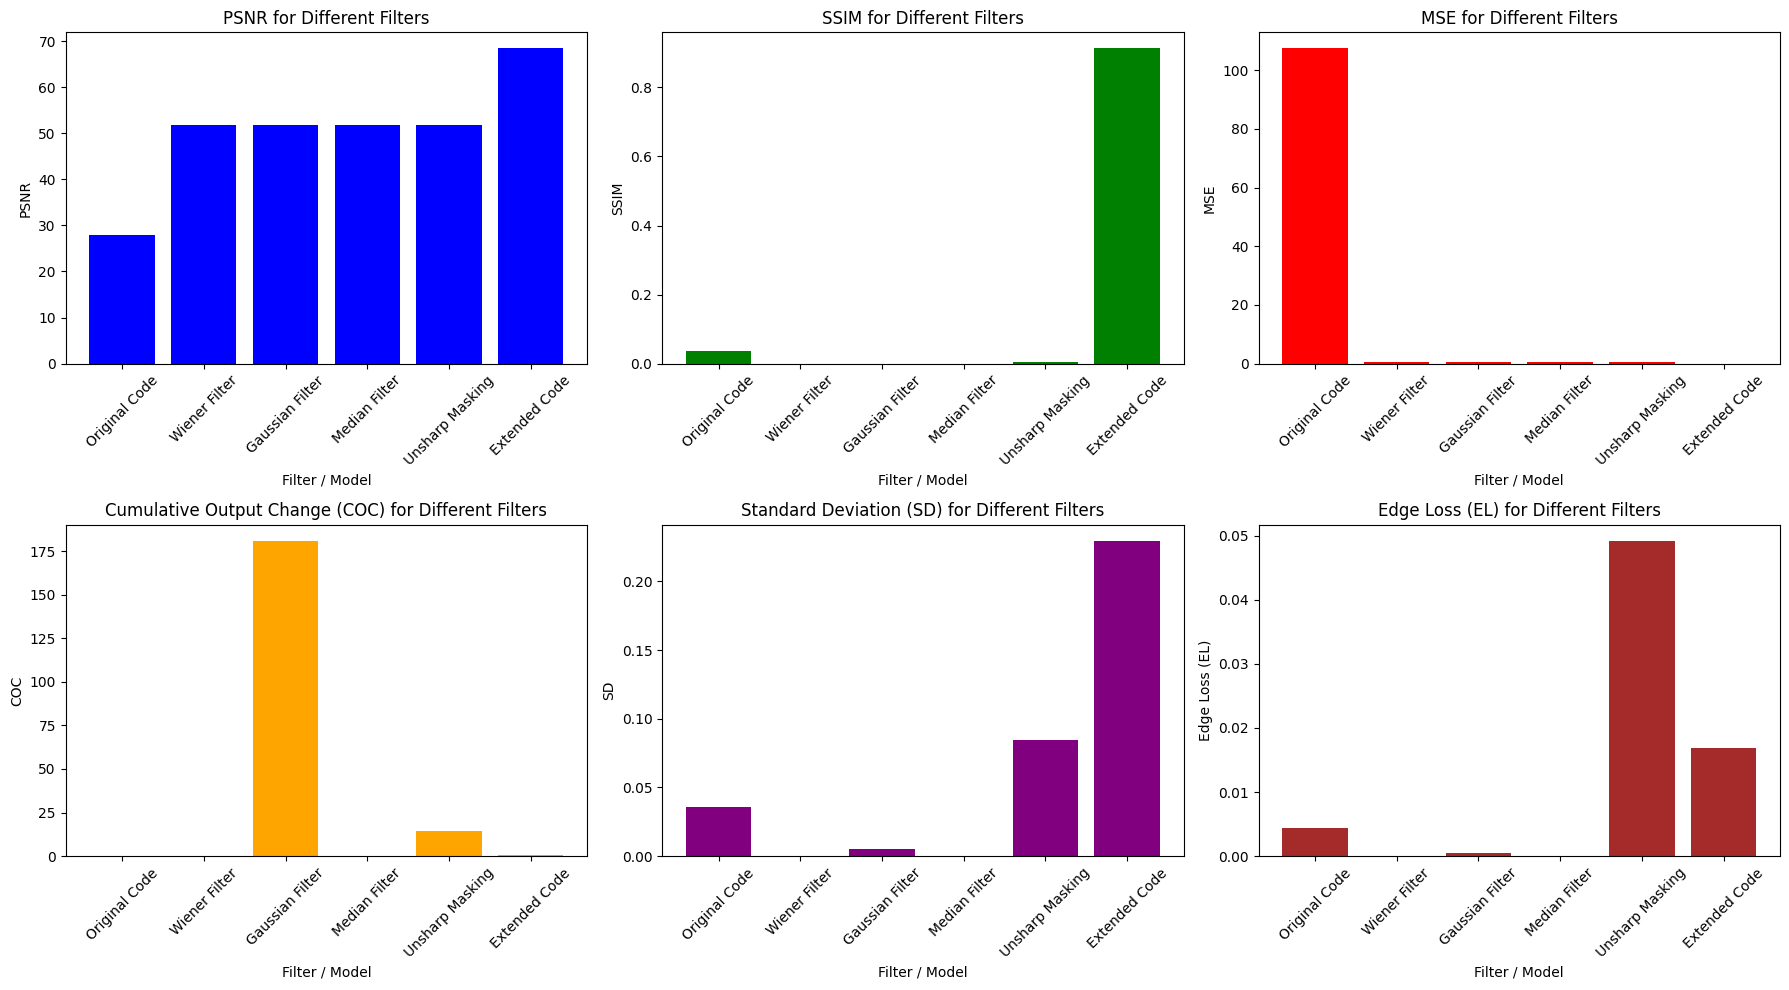

In [ ]:
# Plot the comparision for different filters and models on the histology dataset
compare_and_plot(image)